# Looking for hosted astrophysical transients with CNNs + MLPs (ACAI)

<img src="https://miro.medium.com/v2/resize:fit:1400/0*n6zzxzDrGFPV6Tue.png" style="height: 400px" />

"*Astronomy has been experiencing an explosive increase in the data volumes, doubling every two years or so.*

*At the forefront of this revolution, the  Zwicky Transient Facility (ZTF) – a robotic sky survey – registers millions of transient events (supernova explosions, asteroids, variable stars changing their brightness etc.) in the dynamic sky every (clear) night.*

*Here we present astrophysical Alert-Classifying AI (ACAI), an open-source DL framework for the phenomenological classification of ZTF events.*"

`Dima Duev, et al. (2021) [arXiv:2111.12142](https://arxiv.org/abs/2111.12142)`

---
## Introduction

ZTF simply detects too many things, and depending on your science case, you might be looking for specific types of transients only. Often, the location of the transient in the sky along with other information about what is in its vicinity - or what isn't - can be a good indicator of what type of transient it is, though it is not enough to find its exact nature.

Phenomenological classification of transients will not look for specific types (like SN Ia, SN II, RR Lyrae, AGN, etc.), but rather provide useful information about some of the transient's properties that might help narrow down the search for the exact nature of the transient.

**Alert-Classifying Artificial Intelligence (ACAI)**, comes in 5 flavors of binary classifiers, each trained to answer a specific question about the transient:
- **acai_h**: Transients in the vicinity of a "host" galaxy with detectable morphology, but not located at its nucleus. These objects are likely to be supernovae, novae, or cataclysmic variables near galaxy-like objects.
- **acai_o**: Transients with no identifiable host galaxy, but that are unlikely to be variable stars in our own galaxy. These objects are likely to be asteroids, comets, hostless (or very distant and/or faint hosts) transients.
- **acai_n**: Transients located at the nucleus of their host galaxy. These objects are likely to be active galactic nuclei (AGN), or TDEs.
- **acai_v**: Transients that are not only detectable in the new/science image but in the reference image, with positive or negative subtraction (positive or negative changes in brightness when compared to the reference image), detected regularly. These objects are likely to be variable stars.
- **acai_b**: Alerts that are unlikely to be real astrophysical transients. These objects are likely to be artifacts, noise, cosmic ray hist, man-made satellites, etc. You'll notice that this is very similar to the existing `drb` (real/bogus) score already provided in the alerts.

*Compared to a model like **BRAAI** (ZTF's image-only real/bogus classifier), **ACAI** is multi-modal, meaning it uses both the image and the alert's metadata to make a decision. The architecture of models like **BTSbot** is inspired by ACAI, but they rely on different metadata features and are trained to answer a different question.*

**In this notebook**, we will focus on **acai_h**, which along with other filtering steps can help us identify SNe candidates in the ZTF alert stream, or other fast evolving hosted transients.

---
### Select the Google Colab runner *(optional, only if running on Colab)*:

You'll want to click on `Runtime` (top left of the screen) -> `Change runtime type` -> then select `T4 GPU`.


##### **Suggestion**:
For those that have ~30GB (necessary while decompressing the dataset, but only ~20GB needed after that) to spare, we really encourage you to run this notebook on your own machine. Though it will run on colab, reading from disk on colab is surprisingly slower than on most low-end laptops. Since we have lots of image data in this dataset (more than can fit in memory), we need to read it from disk. Therefore we really recommend running all of this locally if you are able to.

---
### Install and Import Libraries

Let's start by importing the necessary python libraries/packages. Today we'll use:
- `numpy` for fast numerical operations and array handling
- `pandas` for data manipulation and analysis + dataframe support
- `matplotlib` for plotting and visualization
- `tensorflow` for building and training the CNN + MLP (multi-modal model)
- `os` for file handling and directory operations
- `io` for handling file/bytes streams
- `astropy` for handling astro file formats andastro-related visualization
- `datetime` for handling dates and times where needed.

*PS: you might get some warnings especially coming from `astropy` and `tensorflow`, you can ignore them for now. Please reach out to one of the instructors (or by email at tdulaz@caltech.edu) if you encounter any issues.*

In [1]:
import datetime
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf # can take some time the first time this is imported

from astropy.io import fits
from astropy.visualization import (
    AsymmetricPercentileInterval,
    ImageNormalize,
    LinearStretch,
    LogStretch,
)
from tensorflow.data import Dataset
from tensorflow.keras import layers, Model, optimizers

2024-08-02 11:41:58.076726: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 11:41:58.095309: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
## Dataset

The dataset is composed of ~200k individual ZTF alerts (individual detections of many transients, not individual transients, meaning that the number of unique objects is much lower) labeled as: `h` (hosted), `o` (orphan), `n` (nuclear), `v` (variable), and `b` (bogus). Later on, the dataset will be split into training, validation, and test sets, with 80%, 10%, and 10% of the data in each set, respectively.

*Like in most datasets, the classes are imbalanced, with the `v` (variable) class being the most common, and the `h` (hosted) and `o` (orphan) classes being the least common. To ensure good performance of a model, it will be important to assign weights to each classes, to give more importance to the classes that appear less frequently, effectively balancing the dataset.*

**Let's start by downloading the dataset (~8GB compressed, ~17GB uncompressed) and decompressing it.**

For that, make sure you pinned https://drive.google.com/file/d/1PsbKYzMxmUFzGN4UFSQxfnYP2fofQHnj/view?usp=drive_link to your own Google drive. Then, run the cell above to attach this notebook to your drive.

Next up, replace (if necessary only) this path by the path to the file in your google drive. We'll use it to decompress the dataset, and put it in the right place.

**This will ~6 minutes to run, as the dataset is composed of many small files.** I strongly suggest scrolling through the notebook to use that time to understand some of the code and the data. **DO NOT RUN IT AGAIN.** Just uncomment it, run it, and comment it out again.

In [2]:
#!cd /tmp && tar -xvzf /content/drive/MyDrive/acai_dataset/acai_data.tar.gz

**Dataset details:**

The dataset found in `data` is composed of:
- `d1.csv` - is a dataframe (table) with 3 columns: `objectId`, `candid`, and a `label` (h, o, n, v, b). The `objectId` and `candid` columns are used to match the alerts with the images, and in general useful to keep track of the object's name if you'd like to look it up online to see the lightcurve or some more metadata. You can use any of the public brokers for that, e.g. Fink, Alerce, ANTARES, etc.
- `features.d1.npy` - is a numpy array with the features extracted from the alerts. `acai` models use a total of 25 metadata features, so this is how many values you'll find in each element of the array. It's essentially a 2D array with shape `(n, 25)`, where `n` is the number of alerts in the dataset. The features here are ordered in the same way as the alerts in the `d1.csv` file, so no need to worry about matching them as long as you keep the order.
- `triplets/<candid>.npy` - where candid is the `candid` of an alert. The `triplets` folder contains the cutouts of the alerts, which are 3D arrays with shape `(63, 63, 3)`. The first element is the science image, the second is the reference image, and the third is the difference image. The difference image is the subtraction of the science and reference images, and it's the one from which we extra the photometry and some of the features. If anything changed in the sky, it should be visible in the difference image. The data in there is already normalized, so you can use it directly to train a model.

**Let's start by loading the data from `d1.csv` and `features.d1.npy` files, and creating a list of file paths for the cutouts/images.**

In [3]:
dataset_path = os.path.join(os.getcwd(), 'data', 'acai_data')

# here we load the metadata features
features = np.load(f'{dataset_path}/features.d1.npy')

# here we load the labels + candid so we can match the images files with the labels later
labels = pd.read_csv(f'{dataset_path}/d1.csv')

# using the candid column, create an ordered list of the files we want to load to get the images
triplets = np.array([f"{dataset_path}/triplets/{candid}.npy" for candid in labels.candid.values])

# verify that all files exist
for triplet in triplets:
    assert os.path.exists(triplet), f'Missing {triplet}!!!'

**Next let's print the shapes of:**
- the features
- the labels
- the shape of the images = nb images x dimension of one image

In [4]:
nb_images, image = len(triplets), np.load(triplets[0])

print(f"We have {nb_images} images of shape {image.shape}")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# verify that the number of entries matches, throws an error if not
assert features.shape[0] == labels.shape[0] == nb_images

We have 186319 images of shape (63, 63, 3)
Features shape: (186319, 25)
Labels shape: (186319, 3)


*You might be wondering why we can't just load the images in one go just like we do for the features and labels. The reason is that the images are too large to fit all of them in memory at once, so we'll have to load them in batches during training, validation, and testing.*

**Let's take a look at each of the files and their contents. We'll start with `d1.csv`:**

In [5]:
# let's look at `d1.csv` first 10 rows
labels.head(10)

,objectId,label,candid
0,ZTF18aamdfrd,v,832404312515015010
1,ZTF18aamdfrd,v,1154531552515015058
2,ZTF18aamdfrd,v,828336622515015005
3,ZTF18aabeofd,v,1316186040315010000
4,ZTF18aabeofd,v,1242291070315010002
5,ZTF18aabeofd,v,1182374230315010056
6,ZTF17aaaduya,v,1047205065915010001
7,ZTF17aaaduya,v,1140102715915010005
8,ZTF17aaaduya,v,676199575915010003
9,ZTF18aatwnet,v,1259381461515015014


In [6]:
# let's get an idea of how unbalanced the dataset is. For that, we can compute percentage of each class
labels.groupby("label").size() / len(labels) * 100

label
b    15.082734
h    15.345724
n    19.059248
o    13.934167
v    36.578127
dtype: float64

Turns out that most classes are balanced, but we clearly have more examples of `v` (variable) alerts than the other classes. This makes a lot of sense since these variable stars are long lived transients we detect often (pretty much at every visit of a ZTF field). The `o` (orphan) classe is the least common, which is also expected since these are things like solar system objects. They are common too, but since we detect them often only once at a given position (meaning just one alert for a given objectId since the names are spatially associated), so it can get a little hard to tell them apart from noise/bogus alerts.

**Next, let's look at the metadata features from `features.d1.npy`:**

In [7]:
# let's look at the first 1 row of the 25 features, along with their names
ACAI_H_FEATURES = ('drb', 'diffmaglim', 'ra', 'dec', 'magpsf', 'sigmapsf', 'chipsf', 'fwhm', 'sky', 'chinr', 'sharpnr', 'sgscore1', 'distpsnr1', 'sgscore2', 'distpsnr2', 'sgscore3', 'distpsnr3', 'ndethist', 'ncovhist', 'scorr', 'nmtchps', 'clrcoeff', 'clrcounc', 'neargaia', 'neargaiabright')

# make a quick dataframe of 10 rows
pd.DataFrame(features[:10, :25], columns=ACAI_H_FEATURES)

,drb,diffmaglim,ra,dec,magpsf,sigmapsf,chipsf,fwhm,sky,chinr,...,sgscore3,distpsnr3,ndethist,ncovhist,scorr,nmtchps,clrcoeff,clrcounc,neargaia,neargaiabright
0,0.999961,20.573124,215.887714,40.188635,20.122263,0.187672,1.116026,2.770000,-0.110588,0.541,...,0.799857,26.719685,69.0,699.0,10.027220,4.0,-0.071005,0.000030,0.263039,-999.0
1,0.991094,20.497231,215.888024,40.188552,20.180290,0.213557,1.277902,2.240000,-0.327813,0.541,...,0.009375,26.132204,109.0,1259.0,7.601007,4.0,-0.082270,0.000371,0.680922,-999.0
2,0.999996,20.812113,215.887844,40.188619,19.646261,0.114800,1.048080,2.010000,0.010978,0.541,...,0.799857,26.574293,60.0,675.0,12.571731,4.0,-0.061227,0.000017,0.135656,-999.0
3,0.999980,20.316908,215.545482,30.056814,18.875511,0.090739,6.044485,2.340000,-0.431299,0.459,...,0.004167,9.024582,1043.0,2083.0,8.938406,7.0,0.103461,0.000017,0.132948,-999.0
4,0.999813,20.450735,215.545448,30.056762,19.368765,0.164716,3.470039,1.880000,0.012167,0.459,...,0.004167,8.807810,965.0,1956.0,11.635296,7.0,0.104410,0.000015,0.317949,-999.0
5,0.992333,20.357897,215.545501,30.056807,19.169968,0.120456,8.718287,1.176057,4.258265,0.694,...,0.004167,9.025195,881.0,1791.0,8.490078,7.0,0.186078,0.000028,0.086825,-999.0
6,0.999946,19.422346,10.732041,43.098274,17.987194,0.094823,3.697674,1.370723,-0.168426,1.296,...,0.986500,10.467785,668.0,1112.0,8.429641,16.0,-0.013026,0.000024,0.505201,-999.0
7,0.992826,21.232424,10.732041,43.098349,18.252439,0.045721,49.119545,3.410000,-7.260237,0.410,...,0.986500,10.607390,707.0,1181.0,13.302192,15.0,-0.038162,0.000004,0.244113,-999.0
8,0.999334,20.710741,10.732035,43.098405,18.125805,0.110031,18.667473,2.800000,0.011822,0.507,...,0.986500,10.724013,250.0,527.0,15.774800,15.0,0.086108,0.000003,0.113847,-999.0
9,0.999970,20.187872,221.046557,51.278432,19.621469,0.173033,1.983008,1.444748,-0.084811,0.454,...,0.946792,17.504427,1823.0,3420.0,5.932185,5.0,-0.079316,0.000027,1.052316,-999.0


You'll notice that the features are **not normalized**. This is something we can do before training the model. In this notebook we do not provide you with the normalization code, but we encourage you to try it out on your own. There are many ways to normalize the data, but the most common one is to subtract the mean and divide by the standard deviation of each feature. This is done to ensure that the model trains faster and more efficiently, and that the weights are updated in a way that makes sense for the model.

**CAUTION**: Some features can also have NaN values, or -999.0 which means that there are simply no data for that feature. That will show up for any feature related to a spatial crossmatch with another catalog. If there are simply no matches, well the distance to the non-existing crossmatch or some of its features don't exist. That is something you might need to handle here. You could image normalizing everything except these values, and leaving them as these very large negative numbers. This is something you can try out on your own.

**For a first pass at training, we'll just use the raw features as they are.**

**Now, let's look at the images from the `triplets/` directory:**

We'll look at triplets of a transient of the `h` class, but feel free to run the modify the code to look at other classes. Let's start by plotting the data as is, without any of the transformations that make it easier to see the content of an astronomical image. *But first, we need a couple of methods to read the data and plot it.*

In [8]:
# this method loads the triplets from disk, given a list of files
def load_triplet_from_disk(triplet_files):
    triplets = []
    for f in triplet_files:
        t = np.load(f)
        triplets.append(t)
    return np.array(triplets)


# this method plots the 3 cutouts of an alert without applying any transformation
def show_triplet(triplet):
    triplet = triplet.transpose(2, 1, 0)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axs):
        ax.imshow(triplet[i])
        ax.axis('off')
    plt.show()

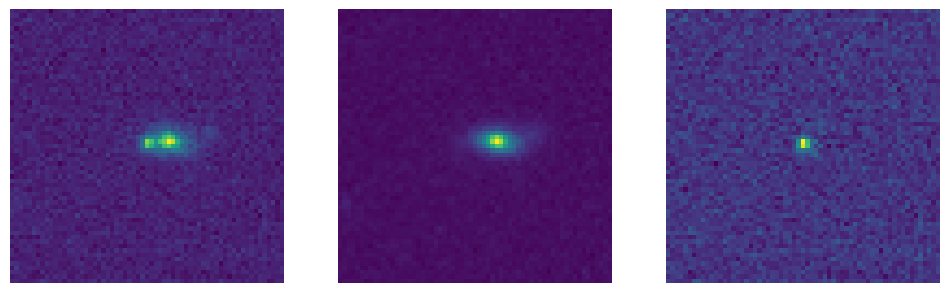

In [9]:
# Let's look at an object with label 'h' (hosted)
entry = labels.iloc[135009]
objectId, candid, label, triplet = entry.objectId, entry.candid, entry.label, load_triplet_from_disk(triplets[135009:135009+1])[0]
show_triplet(triplet)

In the triplet above we can see:
- the science image (left) - the new image, where we can see a bright source in the center, on top of a wider (not point-like) object right next to it, with a slight offset. Likely a galaxy given its morphology.
- the reference image (middle) - the stack of older images, where we can only see the galaxy, but not the bright source. This is how we know that the bright source is new, likely a transient if of astrophysical origin.
- the difference image (right) - the subtraction of the science and reference images, where we can see the bright source very clearly, and the galaxy is subtracted out. This is the image from which we extract the photometry and some of the features.

**Looking at this triplet is very object that this transient is hosted, but it's a little bit hard for a human to tell these things from the images without applying any transformations.
So, let's use `astropy`'s visualization tools to apply some transforms to make it a little bit easier to read the images. Let's write that method first**

In [10]:
def show_thumbnails(
    objectId,
    candid,
    triplet,
    label,
):
    triplet = triplet.transpose(2, 1, 0)
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    for i, ax in enumerate(axs):
        image_data = triplet[i]

        # ZTF-specific transformation to get North up and West on the right,
        image_data = np.flipud(image_data)

        # replace nans with median:
        img = np.array(image_data)

        # replace dubiously large values
        xl = np.greater(np.abs(img), 1e20, where=~np.isnan(img))
        if img[xl].any():
            img[xl] = np.nan
        if np.isnan(img).any():
            median = float(np.nanmean(img.flatten()))
            img = np.nan_to_num(img, nan=median)

        # normalize the image now that we've cleaned it up
        norm = ImageNormalize(
            img,
            stretch=LinearStretch()
            if i == 2 # if it's the subtraction image (which is science - reference), we apply a Log stretch instead.
            else LogStretch(),
        )
        img_norm = norm(img)
        normalizer = AsymmetricPercentileInterval(
            lower_percentile=1, upper_percentile=100
        )
        vmin, vmax = normalizer.get_limits(img_norm)
        # plot the image, with a bone colormap (nice blue-ish + white colors, easy on the eyes)
        ax.imshow(img_norm, cmap="bone", origin="lower", vmin=vmin, vmax=vmax)
        ax.set_axis_off()

    # Add the label to the title
    title = f"{objectId} {candid} {label}"
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

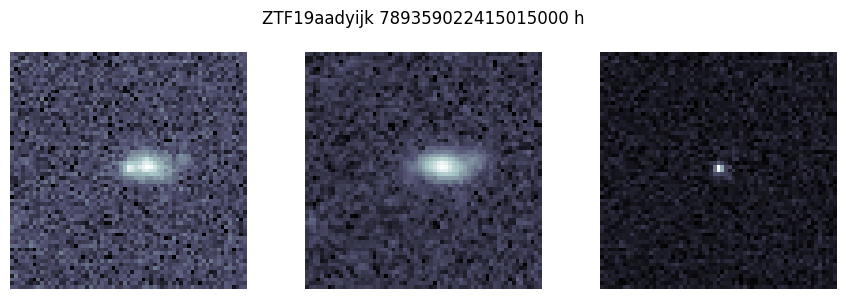

In [11]:
# now we run it on the same object
show_thumbnails(objectId, candid, triplet, label)

The host galaxy's morphology definitely more obvious now, though we can see a lot more noise after the normalization + transformation. This transformation is the same we use to show ZTF alerts to astronomers on platforms like [SkyPortal](https://arxiv.org/abs/2305.00108). However as mentioned earlier, the model doesn't need this transformation to work, it can work with the raw data as well.

**Before we move on to building the model, let's look at a quick example of bogus object.**

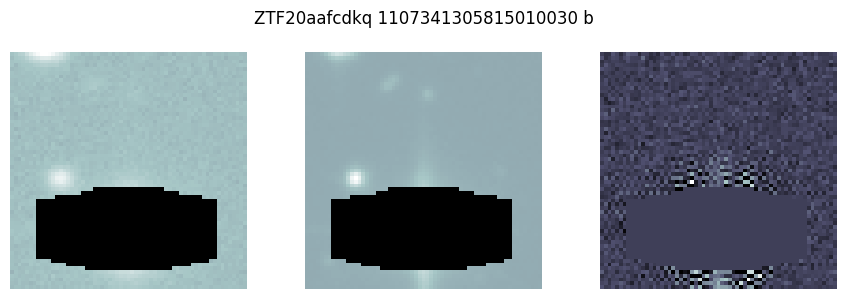

In [12]:
entry = labels.iloc[58017]
objectId, candid, label, triplet = entry.objectId, entry.candid, entry.label, load_triplet_from_disk(triplets[58017:58017+1])[0]
show_thumbnails(objectId, candid, triplet, label)

This one is a little bit of an extreme example, but it's a good one to show what a bogus alert can look like. Even if the subtraction algorithm (ZOGY) is smart, it can be tricked by some things, like cosmic rays, or other artifacts.

Here for example, ZTF masked a very very bright star so we can still extract data from the rest of the image (keep in mind that these cutouts are just a 63x63 image extracted at the position of whatever we detect, but the ZTF images are much much larger), however this still results in a bad subtraction, where we can see that there is no transient whatsoever, but just the scattered light from the masked star. We definitely want to avoid looking at these, which is why we developed models like `acai_b` or `drb` to filter them out systematically.

---
## Model

Now that we have a good understanding of the data, let's move on to building a model that can take it as an input and output a prediction. The model will be a combination of a Convolutional Neural Network (CNN) and a Multi-Layer Perceptron (MLP), which will take the image and the metadata features as inputs, respectively.

What are our requirements:
- We need an image input, made of 3 channels (science, reference, difference, you can compare it to how we could feed it an RGB image, but here we have 3 different images instead).
- We need a metadata input, made of 25 numerical features.
- We need one output, from 0 to 1, where 1 means that the alert is of the positive class, e.g. with `acai_h` (hosted), 1 means that the alert is hosted, and 0 means that it is not.

**In this notebook, we'll focus on predicting the `h` class, which means that the alert has a host galaxy.**

Let's think about the Convolutional Neural Network (CNN) part of the model first, to process the image. We'll use a simple VGG6-like architecture (should be enough given the small size of the images). That branch of the model is essentially the exact same as the `BRAAI` (drb, real/bogus) model, so it looks like:

<img src="https://raw.githubusercontent.com/Theodlz/bts-ml-ztf-summer-school/main/braai_architecture.png" style="height: 400px" />

**Exercise 1:**
Build the CNN part of the model based on the architecture above. The input shape should be `(63, 63, 3)` and the output shape should be `(1,)`. The model should output a single value between 0 and 1, which will be the model's prediction.

*Hint*: You can use the `Conv2D`, `MaxPooling2D`, and `Flatten` layers from `tensorflow.keras.layers`. Don't forget the `Dropout` layers to prevent overfitting.

In [13]:
triplet_input = layers.Input(shape=(63,63,3), name='triplet')

# insert your code here

# first conv block
x_conv = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='conv2d_1_1')(triplet_input)
x_conv = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='conv2d_1_2')(x_conv)
x_conv = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='maxpool_1')(x_conv)
x_conv = layers.Dropout(0.25, name='dropout_1')(x_conv)

# second conv block
x_conv = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2d_2_1')(x_conv)
x_conv = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2d_2_2')(x_conv)
x_conv = layers.MaxPooling2D(pool_size=(2,2), strides=4, name='maxpool_2')(x_conv)
x_conv = layers.Dropout(0.25, name='dropout_2')(x_conv)

# we flatten the output
x_conv = layers.Flatten()(x_conv)
x_conv = layers.Dense(1, activation='relu', name='fc_first')(x_conv)
output = layers.Dense(1, activation='sigmoid', name='fc_out')(x_conv)

cnn_model = Model(inputs=[triplet_input], outputs=output)

In [14]:
# next we just test it on a random input to make sure it works
# essentially we just want to make sure that the model can run on a valid input
fake_input = np.random.rand(1, 63, 63, 3)
cnn_model(fake_input)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4954385]], dtype=float32)>

Awesome, now let's focus on the even simpler metadata branch of the model. This branch will be a simple Multi-Layer Perceptron (MLP) with 2 hidden layers. The model will take the 25 metadata features as input and output a single value between 0 and 1, which will be the model's prediction.

**Exercise 2:**
Build the MLP part of the model with the following architecture:
- Input layer with 25 units
- Dense layer with 64 units and ReLU activation
- Dropout layer with 0.25 rate
- Dense layer with 32 units and ReLU activation
- Dropout layer with 0.25 rate
- Output layer with 1 unit and sigmoid activation

*Hint*: You can use the `Dense` and `Dropout` layers from `tensorflow.keras.layers`.

In [15]:
metadata_input = layers.Input(shape=(25,), name='metadata')

# insert your code here
x_metadata = layers.Dense(64, activation='relu', name='dense1')(metadata_input)
x_metadata = layers.Dropout(0.25, name='dropout1')(x_metadata)
x_metadata = layers.Dense(32, activation='relu', name='dense2')(x_metadata)
x_metadata = layers.Dropout(0.25, name='dropout2')(x_metadata)

output = layers.Dense(1, activation='sigmoid', name='fc_out')(x_metadata)

mlp_model = Model(inputs=metadata_input, outputs=output)

In [16]:
# next we just test it on a random input to make sure it works
# essentially we just want to make sure that the model can run on a valid input
fake_input = np.random.rand(1, 25)
mlp_model(fake_input)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4241018]], dtype=float32)>

Amazing!!! **Now, let's build the multi-modal model that combines the CNN and MLP branches.**

It's almost as simple as adding the two branches together. The only thing we need to do is to concatenate the outputs of the two branches before passing them to the output layer.
**However, a few minor edits are needed, as well as figuring out when to concatenate the two branches.** Indeed, we do not want each branch to output 1 value that we concatenate, but rather the two branches to merge at an earlier stage.

**Exercise 3:**
Build the multi-modal model that combines the CNN and MLP branches. The model should output a single value between 0 and 1, which will be the model's prediction. For that, yoiu'll need to:
- Copy the CNN model, removing anything after the Flatten layer.
- Copy the MLP model, removing anything after the last Dropout layer.
- Use `Concatenate` layer from `tensorflow.keras.layers` to merge the two branches.
- Add a Dense layer with 16 units and ReLU activation.
- Add a final Dense/Output layer with 1 unit and sigmoid activation.

In [17]:
# first we prepare the input layers
triplet_input = layers.Input(shape=(63,63,3), name='triplet')
meta_input = layers.Input(shape=(25,), name='meta')

# # Build the CNN branch
# first conv block
x_conv = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='conv2d_1_1')(triplet_input)
x_conv = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='conv2d_1_2')(x_conv)
x_conv = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='maxpool_1')(x_conv)
x_conv = layers.Dropout(0.25, name='dropout_1')(x_conv)

# second conv block
x_conv = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2d_2_1')(x_conv)
x_conv = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2d_2_2')(x_conv)
x_conv = layers.MaxPooling2D(pool_size=(2,2), strides=4, name='maxpool_2')(x_conv)
x_conv = layers.Dropout(0.25, name='dropout_2')(x_conv)

# we flatten the output
x_conv = layers.Flatten()(x_conv)
x_conv = layers.Dense(1, activation='relu', name='fc_first')(x_conv)
# output = layers.Dense(1, activation='sigmoid', name='fc_out')(x_conv)

# # Build the MLP branch
# insert your code here
x_metadata = layers.Dense(64, activation='relu', name='dense1')(meta_input)
x_metadata = layers.Dropout(0.25, name='dropout1')(x_metadata)
x_metadata = layers.Dense(32, activation='relu', name='dense2')(x_metadata)
x_metadata = layers.Dropout(0.25, name='dropout2')(x_metadata)

# output = layers.Dense(1, activation='sigmoid', name='fc_out')(x_metadata)

# # Combine the two branches and add the rest of the model before the output
x = layers.Concatenate()([x_conv, x_metadata])

output = layers.Dense(1, activation='sigmoid', name='fc_out')(x)

model = Model(inputs=[triplet_input, meta_input], outputs=output, name="acai")

In [18]:
# next we just test it on a random input to make sure it works
# essentially we just want to make sure that the model can run on a valid input
fake_triplet = np.zeros((1, 63, 63, 3))
fake_meta = np.zeros((1, 25))

model.predict([fake_triplet, fake_meta])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


array([[0.5]], dtype=float32)

**Exercise 4:**
- Write all of this up in a method called `build_model` that takes a config object that will allow you to change things like the inputs shape, dropout rate, ... easily.
- The method should return the model **compiled** with the `adam` optimizer and the `binary_crossentropy` loss function.

*But first here is the config*

In [19]:
config = {
    'triplet_input_shape': (63, 63, 3),
    'metadata_input_shape': (25,),
    'batch_size': 32,
    'random_seed': 42,
    'epochs': 5,
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'learning_rate': 0.001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'LR_plateau_patience': 3,
    'reduce_LR_factor': 0.1,
    'reduce_LR_minLR': 0.00001,
    'early_stopping_patience': 5,
    'dropout_rate_1': 0.2,
    'dropout_rate_2': 0.2,
    'dropout_rate_3': 0.2,
}

In [20]:
#CAUTION: to remove before Friday
def build_model(config):
    triplet_input = layers.Input(shape=config['triplet_input_shape'], name='triplet')
    metadata_input = layers.Input(shape=config['metadata_input_shape'], name='metadata')

    # add your code here
    # # Build the CNN branch
    # first conv block
    x_conv = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='conv2d_1_1')(triplet_input)
    x_conv = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='conv2d_1_2')(x_conv)
    x_conv = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='maxpool_1')(x_conv)
    x_conv = layers.Dropout(config['dropout_rate_1'], name='dropout_1')(x_conv)
    
    # second conv block
    x_conv = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2d_2_1')(x_conv)
    x_conv = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2d_2_2')(x_conv)
    x_conv = layers.MaxPooling2D(pool_size=(2,2), strides=4, name='maxpool_2')(x_conv)
    x_conv = layers.Dropout(config['dropout_rate_2'], name='dropout_2')(x_conv)
    
    # we flatten the output
    x_conv = layers.Flatten()(x_conv)
    x_conv = layers.Dense(1, activation='relu', name='fc_first')(x_conv)
    # output = layers.Dense(1, activation='sigmoid', name='fc_out')(x_conv)
    
    # # Build the MLP branch
    # insert your code here
    x_metadata = layers.Dense(64, activation='relu', name='dense1')(meta_input)
    x_metadata = layers.Dropout(config['dropout_rate_3'], name='dropout1')(x_metadata)
    x_metadata = layers.Dense(32, activation='relu', name='dense2')(x_metadata)
    x_metadata = layers.Dropout(config['dropout_rate_3'], name='dropout2')(x_metadata)
    
    # output = layers.Dense(1, activation='sigmoid', name='fc_out')(x_metadata)
    
    # # Combine the two branches and add the rest of the model before the output
    x = layers.Concatenate()([x_conv, x_metadata])

    output = layers.Dense(1, activation='sigmoid', name='fc_out')(x)

    model = Model(inputs=[triplet_input, meta_input], outputs=output, name="acai")

    optimizer = optimizers.Adam(
        learning_rate=config['learning_rate'],
        beta_1=config['beta_1'],
        beta_2=config['beta_2']
    )
    model.compile(optimizer=optimizer, loss=config['loss'], metrics=config['metrics'])

    return model

In [21]:
# try it out!
model = build_model(config)

fake_input_triplet = np.zeros((1, 63, 63, 3))
fake_input_meta = np.zeros((1, 25))

print(model.predict([fake_input_triplet, fake_input_meta]))

model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.5]]


Model: "acai"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ triplet             │ (None, 63, 63, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_1 (Conv2D) │ (None, 63, 63,    │        448 │ triplet[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1_2 (Conv2D) │ (None, 63, 63,    │      2,320 │ conv2d_1_1[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_1           │ (None, 31, 31,    │          0 │ conv2d_1_2[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 31, 31,    │          0 │ maxpool_1[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2_1 (Conv2D) │ (None, 31, 31,    │      4,640 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2_2 (Conv2D) │ (None, 31, 31,    │      9,248 │ conv2d_2_1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta (InputLayer)   │ (None, 25)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_2           │ (None, 8, 8, 32)  │          0 │ conv2d_2_2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 64)        │      1,664 │ meta[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 32)  │          0 │ maxpool_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 64)        │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2048)      │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32)        │      2,080 │ dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc_first (Dense)    │ (None, 1)         │      2,049 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout2 (Dropout)  │ (None, 32)        │          0 │ dense2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 33)        │          0 │ fc_first[0][0],   │
│ (Concatenate)       │                   │            │ dropout2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc_out (Dense)      │ (None, 1)         │         34 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,483 (87.82 KB)

 Trainable params: 22,483 (87.82 KB)

 Non-trainable params: 0 (0.00 B)

Hurrah!!! **Now that we have the model, we need to come up with a way to feed it batches of data for training, validation, and testing.**

---
## Data Generators

We need our model to loop over the data in batches, and feed it to the model for training, validation, and testing. **First, we need to split our data into training, validation, and testing sets.** We'll choose a 80/10/10 split, respectively. However, feel free to change these values to see how the model performs with different splits.

In [35]:
# split the data in train, validation, and test sets, with 0.8, 0.1, 0.1 proportions
total_n_samples = features.shape[0]
n_train = int(total_n_samples * 0.8)
n_val = int(total_n_samples * 0.1)
n_test = total_n_samples - n_train - n_val

# we shuffle the data, while making sure that the triplets, features, and labels are shuffled in the same way
# if not, we would essentially end up with random labels for the triplets and features

# TODO: maybe this part could be an exercise? It's not too hard which is good, but it's also boring.

# start with randomizing indices so we can reorder the data in the same way
indices = np.arange(total_n_samples)
np.random.shuffle(indices)
triplets = triplets[indices]
features = features[indices]
labels = labels.iloc[indices]

# Next up, we split the data in valid, test, and train sets
triplets_val = triplets[n_train:n_train+n_val]
features_val = features[n_train:n_train+n_val]
labels_val = labels.iloc[n_train:n_train+n_val]

triplets_test = triplets[n_train+n_val:]
features_test = features[n_train+n_val:]
labels_test = labels.iloc[n_train+n_val:]

triplets_train = triplets[:n_train]
features_train = features[:n_train]
labels_train = labels.iloc[:n_train]

Let's take a quick look at the shapes of the features and labels in all 3 sets, to validate that the split was done correctly.
Well also take one random training sample and validate that it's the same as the one we saw earlier. That will help avoid any mistakes in the data shuffling or splitting.

In [36]:
# first print the shapes to make sure everything is correct
print(f"Train: {triplets_train.shape}, {features_train.shape}, {labels_train.shape}")
print(f"Validation: {triplets_val.shape}, {features_val.shape}, {labels_val.shape}")
print(f"Test: {triplets_test.shape}, {features_test.shape}, {labels_test.shape}")

Train: (149055,), (149055, 25), (149055, 3)
Validation: (18631,), (18631, 25), (18631, 3)
Test: (18633,), (18633, 25), (18633, 3)


In [37]:
# Next, grab a random entry in the training labels, get it's corresponding candid, triplet and metadata, and compare it to the original - full - dataset.
idx = np.random.randint(0, len(labels_train))
entry = labels_train.iloc[idx]
candid, label = entry.candid, entry.label
train_t, train_m = load_triplet_from_disk(triplets_train[idx:idx+1])[0], features_train[idx]

# get the same entry (and its index) in the original dataset
idx_full = np.where(labels.candid == candid)[0][0]
entry_full = labels.iloc[idx_full]
candid_full, label_full = entry_full.candid, entry_full.label
full_t, full_m = load_triplet_from_disk(triplets[idx_full:idx_full+1])[0], features[idx_full]

assert candid == candid_full
assert label == label_full
assert np.allclose(train_t, full_t)
assert np.allclose(train_m, full_m)

Great, we successfully shuffled the data and split it into training, validation, and testing sets. One thing we also need to do is to drop the candid and objectId column and only keep the label column in the labels, to make it an array of shape `(n, 1)`.

In [38]:
# labels have 3 columns still, just make it a 1D array from the label column only
labels_train = labels['label'].values
labels_val = labels_val['label'].values
labels_test = labels_test['label'].values

Last but not least, we need to decide which label we want to predict, so we can make label a binary array of shape `(n, 1)` where 1 means that the alert is of the positive class, and 0 means that it is not. You might remember, but we are training a binary classifier, and focusing on the `h` (hosted) class. So, we want to predict whether an alert is hosted or not.
This will also help us compute the class weights, which we'll use to balance the dataset between positive and negative classes.

In [39]:
# make the labels binary, with 1 for 'h' and 0 for anything else
labels_train = (labels_train == 'n').astype(int)
labels_val = (labels_val == 'n').astype(int)
labels_test = (labels_test == 'n').astype(int)

In [40]:
# compute the class weights, which is the proportion of each class in the dataset
# here we use the training set to compute the class weights, because its during training that we need to balance the classes

# CAUTION: we want to give MORE weight to the MINORITY class, so we use the inverse of the class proportions
# weight data on number of ALERTS per class
num_training_examples_per_class = np.array([np.sum(labels_train == 0), np.sum(labels_train == 1)])

# fewer examples -> larger weight
weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
normalized_weight = weights / np.max(weights) # normalize

class_weight = {i: w for i, w in enumerate(normalized_weight)}

print(f"Class weights: {class_weight}")


Class weights: {0: 0.23547159301893802, 1: 1.0}


As you can see, now that all classes that are not `h` are part of the negative class, we have a large imbalance between the positive and negative classes. This is why we need to compute the class weights, to give more importance to the positive class during training. Thankfully with tensorflow, it is very easy to just pass the class weights to the model during training, and it will take care of the rest.

**Now, we need to create the data generators that will loop over the data in batches and feed it to the model.**

Luckily, we can create a simple python generator for that: https://wiki.python.org/moin/Generators

Generators are pretty simple. Say you want a list of integers from 1 to 1 billion that you need to loop over. That would take way too much memory. Instead, you can build a generator that will compute the next integer in the list on the fly, everytime you loop over it. This way, you only need to store the current integer, and the logic to compute the next one. This is very useful when you have a lot of data, and you don't want to load it all in memory at once.

Here we do the same thing, except at each iteration we want to generate a batch of data, for which we need to open some files on disk too. This allows us to use ~2GB of RAM while training, instead of >20GB if we loaded all of the images in memory. However it is slower, but it's a good tradeoff and fast enough for our small model that does not require too many training epochs.

In [43]:
def get_data_generator(n_batches, batch_size, type='training'):
    """Given a number of batches, a batch size, and a type (training, validation, test),
    returns a generator that yields the data in the correct format for the model at each iteration.

    Args:
        n_batches (int): number of batches to generate
        batch_size (int): size of each batch
        type (str): type of data to generate, one of 'training', 'validation', 'test'

    Returns:
        generator: a generator that yields the data in the correct format for the model at each iteration
    """

    def data_generator():
        """Yields the data in the correct format for the model at each iteration, given the type of data to generate."""
        if type == 'training':
            for i in range(n_batches):
                x = triplets_train[i*batch_size:(i+1)*batch_size]
                x = load_triplet_from_disk(x)
                s = features_train[i*batch_size:(i+1)*batch_size]
                y = labels_train[i*batch_size:(i+1)*batch_size]
                yield (x, s), y
        elif type == 'validation':
            for i in range(n_batches):
                x = triplets_val[i*batch_size:(i+1)*batch_size]
                x = load_triplet_from_disk(x)
                s = features_val[i*batch_size:(i+1)*batch_size]
                y = labels_val[i*batch_size:(i+1)*batch_size]
                yield (x, s), y
        elif type == 'test':
            for i in range(n_batches):
                x = triplets_test[i*batch_size:(i+1)*batch_size]
                x = load_triplet_from_disk(x)
                s = features_test[i*batch_size:(i+1)*batch_size]
                y = labels_test[i*batch_size:(i+1)*batch_size]
                yield (x, s), y
    return data_generator

Now let's create the generators using the function we just wrote. We'll create one generator for each set (training, validation, and testing).

In [44]:
dataset_train = Dataset.from_generator(
    get_data_generator(n_batches=len(triplets_train)//config['batch_size'], batch_size=config['batch_size'], type='training'),
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(([None, 63, 63, 3], [None, 25]), [None])
).repeat()
dataset_val = Dataset.from_generator(
    get_data_generator(n_batches=len(triplets_val)//config['batch_size'], batch_size=config['batch_size'], type='validation'),
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(([None, 63, 63, 3], [None, 25]), [None])
).repeat()
dataset_test = Dataset.from_generator(
    get_data_generator(n_batches=len(triplets_test)//config['batch_size'], batch_size=config['batch_size'], type='test'),
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(([None, 63, 63, 3], [None, 25]), [None])
).repeat()

---
## Training

Now, let's train the model!

**Caution:** Google Colab is known for having poor disk reading speed, so training the model might take some time. While you can definitely run the other notebook in the meantime, I suggest:
- reading the rest of the notebook
- reading the other notebook: Real-time filtering of the ZTF data stream

~ 95% validation accuracy should also be more than enough to use the model successfully, so feel free to stop the training when you reach that threshold. That could be as early as ~3 epochs, which shouldn't take more than 20 minutes. For those of you that have a decent machine (even without a GPU, just need an SSD), training the same number of epochs would only take ~2 minutes.

In [ ]:
model = build_model(config)
history = model.fit(
    dataset_train,
    steps_per_epoch=(len(features_train) // config["batch_size"]),
    validation_data=dataset_val,
    validation_steps=(len(features_val) // config["batch_size"]),
    epochs=config["epochs"],
    class_weight=class_weight,
    verbose=1,
)

Epoch 1/5
1379/4657 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.4946 - loss: 5.1079

Unless something horribly wrong has happened, the accuracy should look pretty good already. Even a simple architecture like this one can achieve good results on this dataset. Compared to the other acai models (say the variable model that doesn't have access to a lightcurve for example), `acai_h` can learn a lot just from the images. We plotted some images at the beginning of this notebook, and its clear that telling if an alert is hosted is not so hard to do by eye, even for a human. The model can learn a lot from the images, and the metadata features are just here to help it make a more informed decision. ML doesn't have to always be complicated nor does it have to perform tasks that are impossible for a human to do. The huge advantage of ML is that it can do it very very fast in real time as the data comes in, which is something a human or a lot of humans can't do at all.

**Let's take a look at a few metrics to evaluate the model's performance, and double-check that it did learn something.**

---
## Evaluation

The `history` variable returned by `model.fit(...)` contains the training and validation loss and accuracy for each epoch. Let's start the model evaluation by plotting the training and validation loss and accuracy as a function of the epoch number, to see how the model performed during training and verify that it did not overfit the training data.

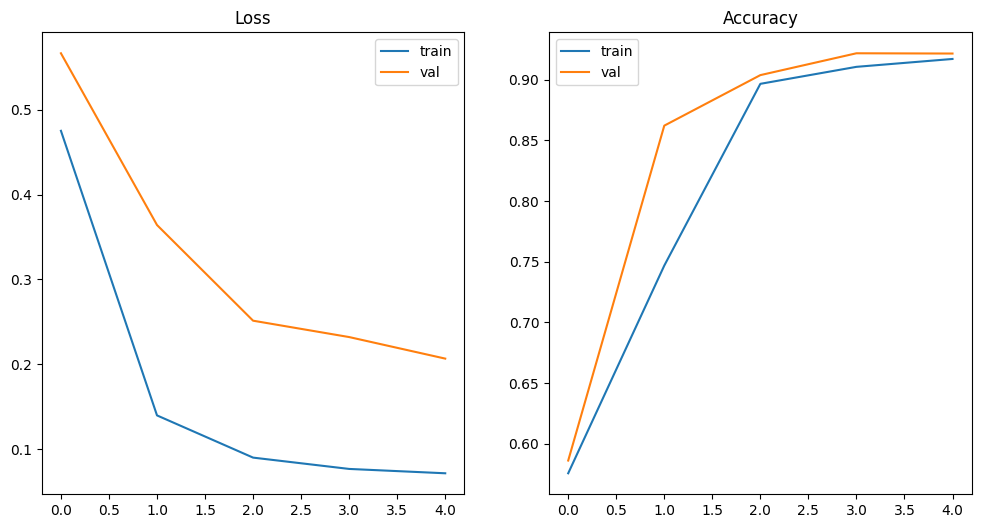

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.show()

**Exercise 5:**
- Compute the accuracy on the test set
- Show a confusion matrix to see how the model performed on the test set (optional).

In [77]:
# insert your code here
loss, acc = model.evaluate(dataset_test, verbose=1, steps=(len(features_test) // config["batch_size"]))
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9238 - loss: 0.6169
Test loss: 0.6347867846488953
Test accuracy: 0.9230562448501587


**Exercise 6 (optional):**
- Compute the accuracy, precision, recall, and F1 score of the model on the training, validation, and testing sets.
- Plot the ROC curve and compute the AUC score of the model on the testing set.

*Hint*: You can use the `sklearn.metrics` module to compute the metrics and plot the ROC curve.

582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


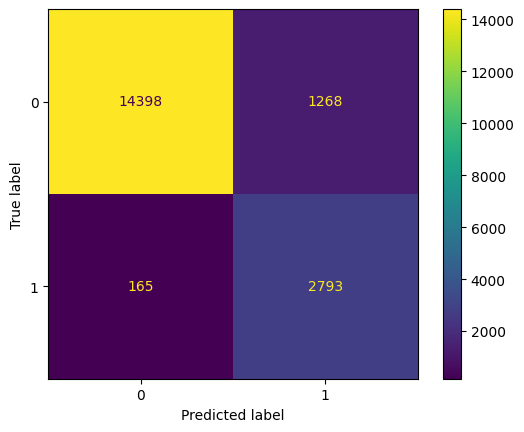

In [84]:
# insert your code here
threshold = 0.5

from sklearn import metrics

pred = model.predict(dataset_test, verbose=1, steps=(len(features_test) // config["batch_size"]))
y_pred = (pred >= 0.5).astype(int)

metrics.ConfusionMatrixDisplay.from_predictions(
    labels_test[:len(y_pred)],
    y_pred
)

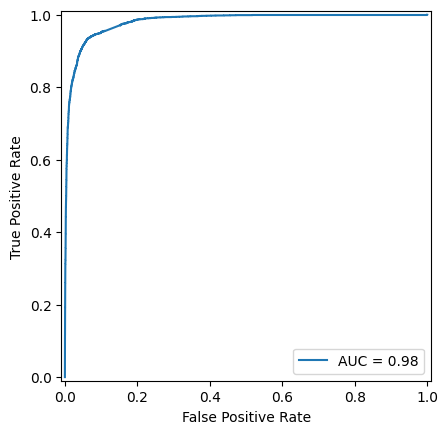

In [106]:
fpr, tpr, _ = metrics.roc_curve(labels_test[:len(y_pred)], pred)
auc = metrics.auc(fpr, tpr)

fig = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
fig.plot()

---
## Saving the model

**Almost done! Let's save the model to disk, so we can import it where we want to run real-time inference on a ZTF alert stream.**

In [107]:
# save the model
# create a name like acai_h_YYMMDD_HHMMSS.h5
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f"acai_h_{now}.keras")

Last but not least, if you are on Google Colab, **right click on the model in the list of file -> click download**, so you can later import that model whenever you need to use it.

**Keep in mind that you can EASILY use this dataset to train other models, that could be more interesting depending on your science case.**

---
## Thanks

Thank you for going through that notebook!
Feel free to use it as a resource for future projects, and don't hesitate to reach out to me by [email](mailto:tdulaz@caltech) with any question.

*Also, big thanks to Dima Duev for developing these `ACAI` models in the first place. These multi-modal architecture applied to astronomical alerts helped develop other models like `BTSbot` that we now use to create end-to-end automated SN discovery+identification+ spectral classification systems for the Zwicky Transient Facility.*